# Проект: классификация

Банки хранят огромные объёмы информации о своих клиентах. Эти данные можно использовать для того, чтобы оставаться на связи с клиентами и индивидуально ориентировать их на подходящие именно им продукты или банковские предложения.

Обычно с выбранными клиентами связываются напрямую через разные каналы связи: лично (например, при визите в банк), по телефону, по электронной почте, в мессенджерах и так далее. Этот вид маркетинга называется прямым маркетингом. На самом деле, прямой маркетинг используется для взаимодействия с клиентами в большинстве банков и страховых компаний. Но, разумеется, проведение маркетинговых кампаний и взаимодействие с клиентами — это трудозатратно и дорого.

**Бизнес-задача**: определить характеристики, по которым можно выявить клиентов, более склонных к открытию депозита в банке, и за счёт этого повысить результативность маркетинговой кампании.

**Техническая задача** для вас как для специалиста в Data Science: построить модель машинного обучения, которая на основе предложенных характеристик клиента будет предсказывать, воспользуется он предложением об открытии депозита или нет.

## Основные цели:
* Исследовать данные
* Выявить характерные черты для потенциальных клиентов, чтобы чётко очертить ЦА и увеличить прибыль банка
* Использовать разные инструменты для повышения качества прогноза

## Этапы:
1. Первичная обработка данных
2. Разведывательный анализ данных (EDA)
3. Отбор и преобразование признаков
4. Решение задачи классификации: логистическая регрессия и решающие деревья
5. Решение задачи классификации: ансамбли моделей и построение прогноза

In [325]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from  sklearn.ensemble import IsolationForest
import warnings
warnings.filterwarnings('ignore')
from sklearn.preprocessing  import LabelEncoder
from sklearn import linear_model 
from sklearn import tree 
from sklearn import ensemble 
from sklearn import metrics 
from sklearn import preprocessing 
from sklearn.model_selection import train_test_split 
from sklearn.feature_selection import SelectKBest, f_classif

## Знакомство с данными, обработка пропусков и выбросов

In [326]:
df = pd.read_csv('data/bank_fin.csv', sep = ';')
df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,deposit
0,59,admin.,married,secondary,no,"2 343,00 $",yes,no,unknown,5,may,1042,1,-1,0,unknown,yes
1,56,admin.,married,secondary,no,"45,00 $",no,no,unknown,5,may,1467,1,-1,0,unknown,yes
2,41,technician,married,secondary,no,"1 270,00 $",yes,no,unknown,5,may,1389,1,-1,0,unknown,yes
3,55,services,married,secondary,no,"2 476,00 $",yes,no,unknown,5,may,579,1,-1,0,unknown,yes
4,54,admin.,married,tertiary,no,"184,00 $",no,no,unknown,5,may,673,2,-1,0,unknown,yes


In [327]:
# исследуем данные на предмет пропусков
df.isnull().sum()

age           0
job           0
marital       0
education     0
default       0
balance      25
housing       0
loan          0
contact       0
day           0
month         0
duration      0
campaign      0
pdays         0
previous      0
poutcome      0
deposit       0
dtype: int64

Пропущенные (неизвестные) значения могут присутствовать неявным образом. Это значит, что они могут быть закодированы каким-то словом или набором символов. Часто это не является проблемой, но это необходимо выявить.

In [328]:
# есть ли в признаке job пропущенные значения? Возможно, они обозначены каким-то специальным словом?
df["job"].unique()

array(['admin.', 'technician', 'services', 'management', 'retired',
       'blue-collar', 'unemployed', 'entrepreneur', 'housemaid',
       'unknown', 'self-employed', 'student'], dtype=object)

Очевидно, что словом **"unknown"** закодированы пропуски

Признак **balance**: в данных содержится лишняя запятая и знак доллара. По этой причине этот признак не считывается как число.

In [329]:
# преобразуйем признак balance таким образом, чтобы он корректно считывался, как вещественное число (float)
df["balance"] = df["balance"].str.replace(",", ".")
df["balance"] = df["balance"].str.replace("$", "")
df["balance"] = df["balance"].str.replace(" ", "").astype(float)

In [330]:
round(df["balance"].mean(), 3)

1529.129

Значения в признаке balance приобрели нормальный вид, и теперь мы можем обработать пропуски, которые в нём присутствуют. Так как признак числовой, заменим пропуски на медианные значения.

In [331]:

df["balance"] = df["balance"].fillna(df["balance"].median())
round(df["balance"].mean(), 3)

1526.936

Заменим модальным значением пропуски в признаках **education** и **job**.

In [332]:
df["education"].mode()

0    secondary
Name: education, dtype: object

In [333]:
df["job"].mode()

0    management
Name: job, dtype: object

In [334]:
# обработайте пропуски в категориальных признаках: job и education, заменив их на модальные значения
df["education"] = df["education"].str.replace("unknown", "secondary")
df["job"] = df["job"].str.replace("unknown", "management")

In [335]:
display(df["education"].mode(), df["job"].mode())

0    secondary
Name: education, dtype: object

0    management
Name: job, dtype: object

In [336]:
round(df[(df["education"] == "secondary") & (df["job"] == "management")]["balance"].mean(), 3)

1598.883

Изучим признак, отображающий баланс клиентов, на предмет выбросов с помощью метода Тьюки.

In [337]:
q_75 = np.percentile(df["balance"], 75)
q_25 = np.percentile(df["balance"], 25)
iqr = q_75 - q_25
lower_bound = q_25 - iqr*1.5
upper_bound = q_75 + iqr*1.5

print("Верхняя граница Тьюки: {}".format(upper_bound))
print("\nНижняя граница Тьюки: {}".format(lower_bound))

Верхняя граница Тьюки: 4063.0

Нижняя граница Тьюки: -2241.0


In [338]:
# удалим все выбросы для признака balance
df = df[(df["balance"] >= -2241.0) & (df["balance"] <= 4063.0)]
df.shape

(10105, 17)

## Разведывательный анализ

Изучим распределение целевой переменной: есть ли несбалансированность классов? 

In [339]:
deposit_data = df["deposit"].value_counts()
deposit_data

no     5424
yes    4681
Name: deposit, dtype: int64

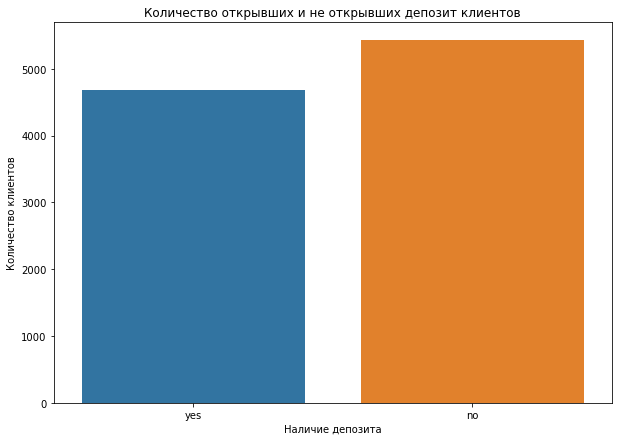

In [340]:
fig, ax = plt.subplots(figsize=(10,7))
sns.countplot(data=df, x="deposit", ax=ax)
ax.set_title("Количество открывших и не открывших депозит клиентов")
ax.set_xlabel("Наличие депозита")
ax.set_ylabel("Количество клиентов");

Как видим, количество клиентов, не открывших депозит, превалирует. 

### Описательная статистика 

In [341]:
#рассчитаем описательные статистики для количественных переменных

fig = px.box(data_frame=df, x="age", title="Распределение возраста клиентов", width=1200, height=500)
fig.show()

In [342]:
round(df["age"].mean())

41

Минимальный возраст клиентов - **18 лет**.  
Максимальный возраст клиентов - **95 лет**.  
Медианный возраст - **38 лет**, а средний - **41 год**.

In [343]:
fig = px.box(data_frame=df, x="duration", title="Распределение продолжительности контакта", width=1200, height=500)
fig.show()

In [344]:
round(df["duration"].mean())

369

Минимальная продолжительность контакта - **2 секунды**.  
Максимальная продолжительность контакта - **3881 секунда**.  
Средняя продолжительность - **369 секунд**, медианная - **252 секунды**

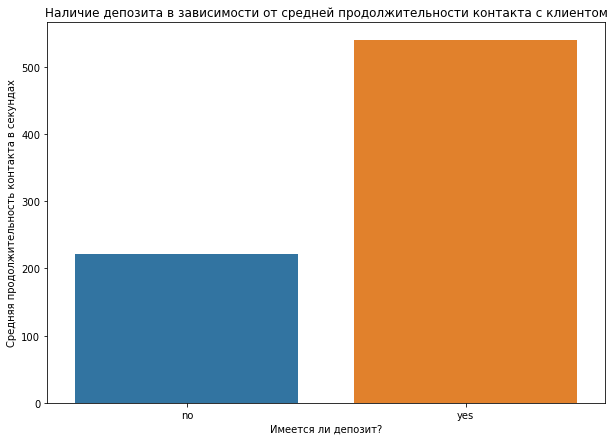

In [345]:
# Зависимость наличия депозита от продолжительности контакта в секундах 
duration_deposit = df.groupby("deposit", as_index=False)["duration"].mean()

fig, ax = plt.subplots(figsize=(10,7))
sns.barplot(data=duration_deposit, x="deposit", y="duration", ax=ax)
ax.set_title("Наличие депозита в зависимости от средней продолжительности контакта с клиентом")
ax.set_xlabel("Имеется ли депозит?")
ax.set_ylabel("Средняя продолжительность контакта в секундах");

На лицо очевидное - человек был заинтересован октрыть депозит, значит, продолжительность разговора была больше. Стоит отметить, что средняя проложительность контакта с клиентом, не открывшим депозит, тоже достаточно продолжительная (около 3,5 минут). Возможно, консультант не смог ответить на все вопросы, или клиентов не устраивали условия.

In [346]:
# Общая статистика по количественным признакам
df[["age", "balance", "duration", "campaign", "pdays", "previous"]].describe()

,age,balance,duration,campaign,pdays,previous
count,10105.000000,10105.000000,10105.000000,10105.000000,10105.000000,10105.000000
mean,40.895497,807.653538,368.742603,2.517170,51.319644,0.816230
std,11.734931,994.151966,346.651524,2.707159,109.644179,2.243795
min,18.000000,-2049.000000,2.000000,1.000000,-1.000000,0.000000
25%,32.000000,95.000000,137.000000,1.000000,-1.000000,0.000000
50%,38.000000,445.000000,252.000000,2.000000,-1.000000,0.000000
75%,48.000000,1227.000000,490.000000,3.000000,2.000000,1.000000
max,95.000000,4063.000000,3881.000000,43.000000,854.000000,58.000000


### Описательные статистика для категориальных переменных

In [347]:
df["month"].nunique()

12

Маркетинговая кампания проходила в течение всего года.

In [348]:
df["job"].unique()

array(['admin.', 'technician', 'services', 'management', 'retired',
       'blue-collar', 'unemployed', 'entrepreneur', 'housemaid',
       'self-employed', 'student'], dtype=object)

Среди клиентов выделяем 11 видов занятости.

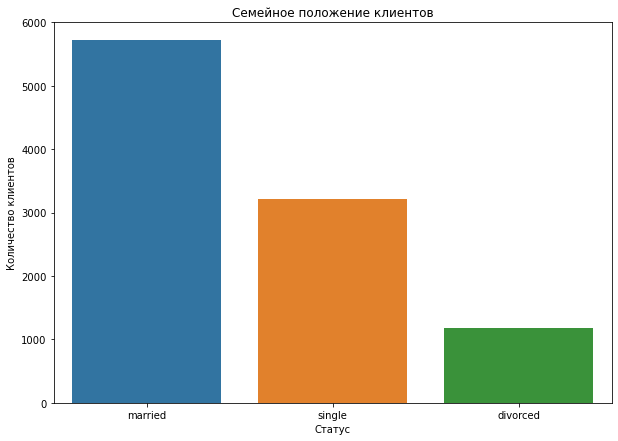

In [349]:
fig, ax = plt.subplots(figsize=(10,7))
sns.countplot(data=df, x="marital", ax=ax)
ax.set_title("Семейное положение клиентов")
ax.set_xlabel("Статус")
ax.set_ylabel("Количество клиентов");

Подавляющее большинство клиентов состоят в браке. Наименьшее количество - разведены.

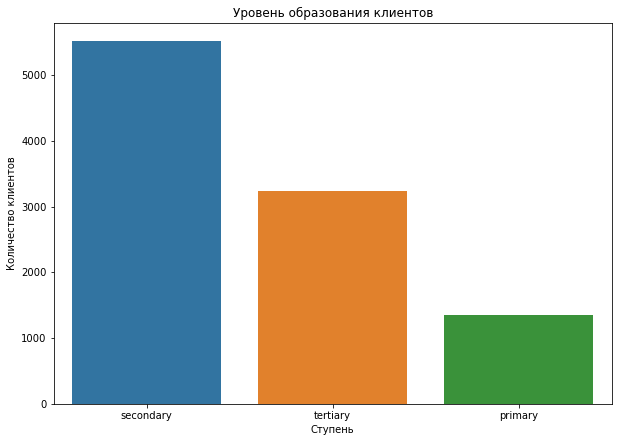

In [350]:
fig, ax = plt.subplots(figsize=(10,7))
sns.countplot(data=df, x="education", ax=ax)
ax.set_title("Уровень образования клиентов")
ax.set_xlabel("Ступень")
ax.set_ylabel("Количество клиентов");

Большинство клиентов имеют **среднее** образование (secondary). Далее идут клиенты с **высшим** образованием (tertiary). Менее всего - с **начальным** образованием (primary) и с неустановленным уровнем образования.

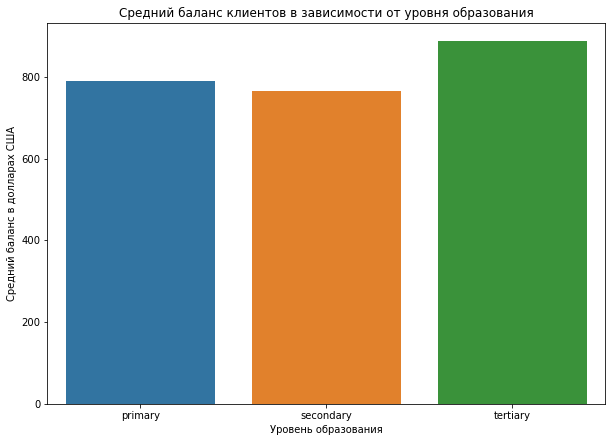

In [351]:
deposit_education = df.groupby("education", as_index=False)["balance"].mean()

fig, ax = plt.subplots(figsize=(10, 7))
sns.barplot(data=deposit_education, x="education", y="balance", ax=ax)
ax.set_title("Средний баланс клиентов в зависимости от уровня образования")
ax.set_xlabel("Уровень образования")
ax.set_ylabel("Средний баланс в долларах США");

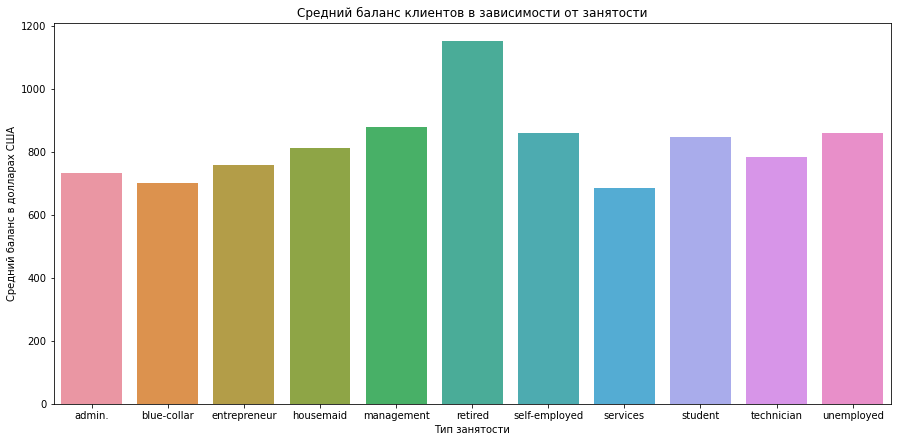

In [352]:
balance_job = df.groupby("job", as_index=False)["balance"].mean()

fig, ax = plt.subplots(figsize=(15, 7))
sns.barplot(data=balance_job, x="job", y="balance", ax=ax)
ax.set_title("Средний баланс клиентов в зависимости от занятости")
ax.set_xlabel("Тип занятости")
ax.set_ylabel("Средний баланс в долларах США");

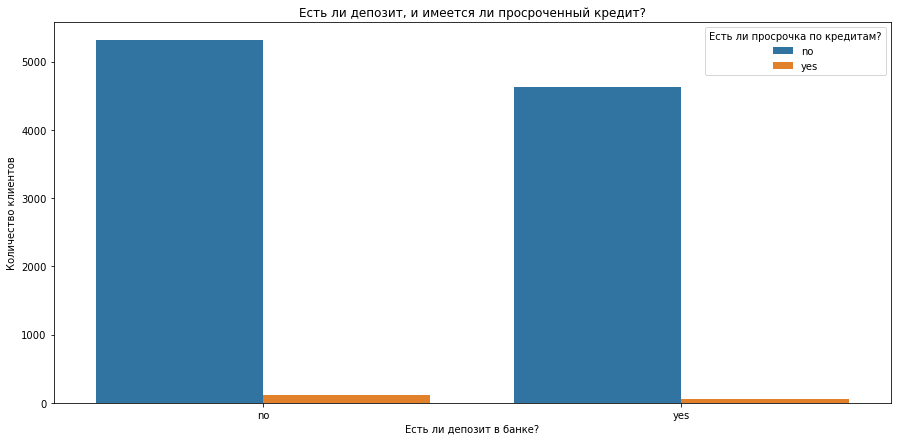

In [353]:
deposit_default = df.groupby("deposit", as_index=False)["default"].value_counts()

fig, ax = plt.subplots(figsize=(15, 7))
sns.barplot(
    data=deposit_default,
    x='deposit',
    y='count',
    hue='default',
    ax=ax
)
ax.set_title("Есть ли депозит, и имеется ли просроченный кредит?")
ax.set_xlabel("Есть ли депозит в банке?")
ax.set_ylabel("Количество клиентов")
plt.legend(title='Есть ли просрочка по кредитам?', loc='upper right');

Из стобчатой диаграммы видно, что из открывших депозит клиентов, большинство добросовестных плательщиков (4629 клиентов, отрывших депозит, не имеют просрочек по кредитам). Наша цель - убедить открыть депозит 5310 клиентов. Именно столько клиентов не имеют просрочки по кредиту, но и депозит тоже не открывают.

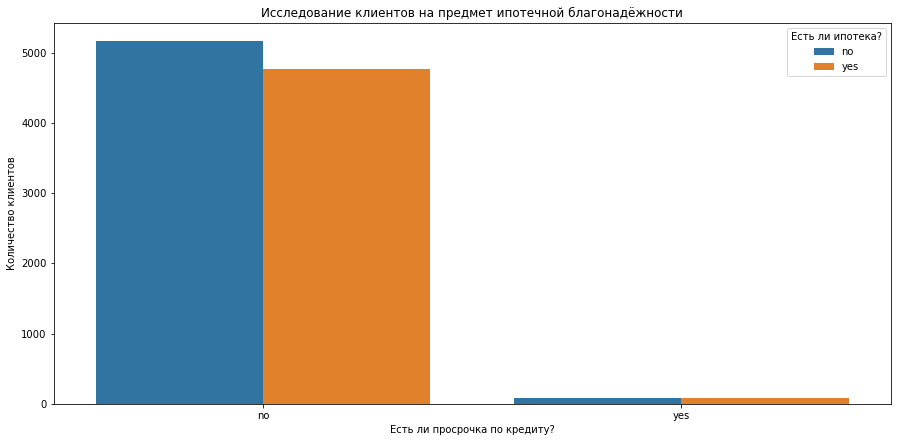

In [354]:
default_housing = df.groupby("default", as_index=False)["housing"].value_counts()

fig, ax = plt.subplots(figsize=(15, 7))
sns.barplot(
    data=default_housing,
    x='default',
    y='count',
    hue='housing',
    ax=ax
)
ax.set_title("Исследование клиентов на предмет ипотечной благонадёжности")
ax.set_xlabel("Есть ли просрочка по кредиту?")
ax.set_ylabel("Количество клиентов")
plt.legend(title='Есть ли ипотека?', loc='upper right');

Большинство клиентов банка - благонадёжные плательщики. Для 5163 клиентов можно подготовить предложение по ипотеке (у них нет ипотеки и не было кредитных просрочек). Естественно, данную категорию клиентов нужно исследовать глубже.

Есть ли разница в результатах текущей маркетинговой кампании и предыдущей? Возможно, люди, которые уже однажды согласились на предложение банка, более склонны принять его вновь. А возможно, ситуация ровно обратная.

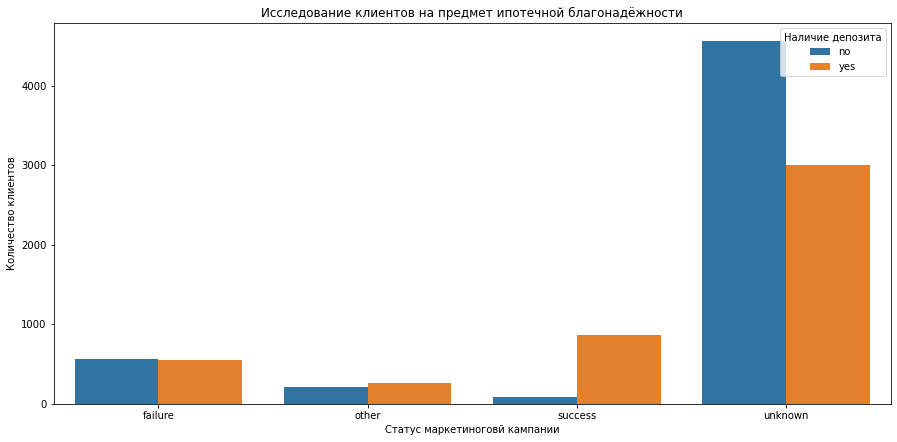

In [355]:
# какого статуса предыдущей маркетинговой кампании успех в текущей превалирует над количеством неудач.
poutcome_deposit = df.groupby("poutcome", as_index=False)["deposit"].value_counts()

fig, ax = plt.subplots(figsize=(15, 7))
sns.barplot(
    data=poutcome_deposit,
    x='poutcome',
    y='count',
    hue='deposit',
    ax=ax
)
ax.set_title("Исследование клиентов на предмет ипотечной благонадёжности")
ax.set_xlabel("Статус маркетиноговй кампании")
ax.set_ylabel("Количество клиентов")
plt.legend(title="Наличие депозита", loc='upper right');

***"success"*** - статус предыдущей кампании, для которого в текущей успехов намного больше, чем неудач.

какова зависимость результата маркетинговых кампаний от месяца?

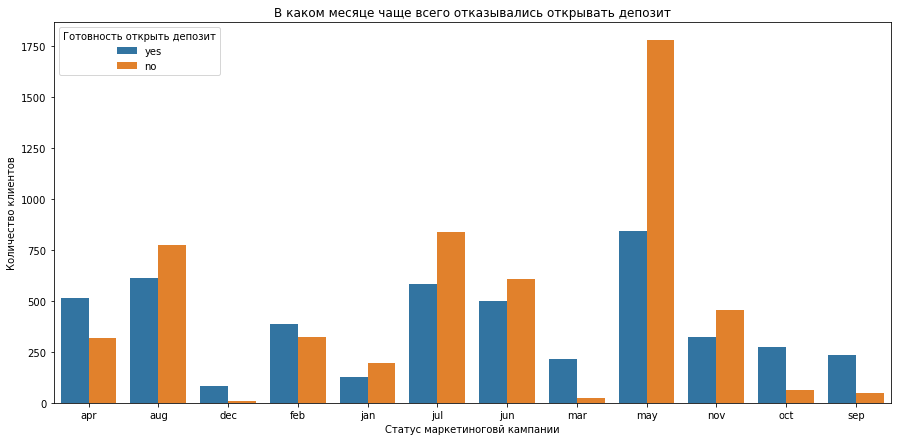

In [356]:
# в каком месяце чаще всего отказывались от предложения открыть депозит
month_deposit = df.groupby("month", as_index=False)["deposit"].value_counts()

fig, ax = plt.subplots(figsize=(15, 7))
sns.barplot(
    data=month_deposit,
    x='month',
    y='count',
    hue='deposit',
    ax=ax
)
ax.set_title("В каком месяце чаще всего отказывались открывать депозит")
ax.set_xlabel("Статус маркетиноговй кампании")
ax.set_ylabel("Количество клиентов")
plt.legend(title="Готовность открыть депозит", loc='upper left');

В мае чаще всего отказывались открывать депозит. Возможно, это связано с подготовкой к сезону отпусков.

Люди какого возраста чаще открывают депозиты, а какого — реже? Однако, так как возрастной разброс достаточно большой, визуализация для всех возрастов или нахождение статистики для каждого возраста не будет содержательной.

Разобьём клиентов на 5 возрастных групп:
* до 30 лет;
* от 30 до 40 лет;
* от 40 до 50 лет;
* от 50 до 60 лет;
* старше 60 лет.

In [357]:
def age_group(age):
    if age < 30: return "<30"
    elif 30 <= age < 40: return "30-40"
    elif 40 <= age < 50: return "40-50"
    elif 50 <= age <= 60: return "50-60"
    elif age > 60: return "60+"
    
df["age_group"] = df["age"].apply(age_group)

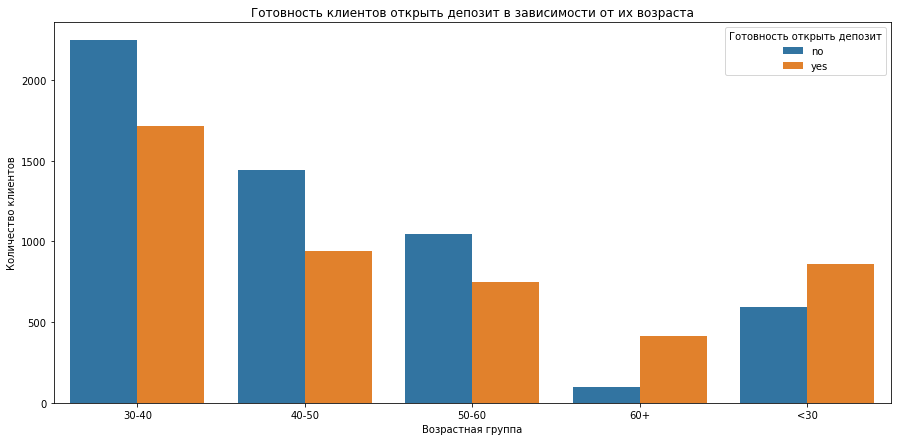

In [358]:
age_group_deposit = df.groupby("age_group", as_index=False)["deposit"].value_counts()

fig, ax = plt.subplots(figsize=(15, 7))
sns.barplot(
    data=age_group_deposit,
    x='age_group',
    y='count',
    hue='deposit',
    ax=ax
)
ax.set_title("Готовность клиентов открыть депозит в зависимости от их возраста")
ax.set_xlabel("Возрастная группа")
ax.set_ylabel("Количество клиентов")
plt.legend(title="Готовность открыть депозит", loc='upper right');

Среди возрастных групп чаще готовы открыть депозит люди до 30 лет и люди старше 60.

Как зависит соотношение успешных и неуспешных контактов с клиентами от категорий, к которым относятся клиенты?
* семейное положение;
* уровень образования;
* сфера занятости.

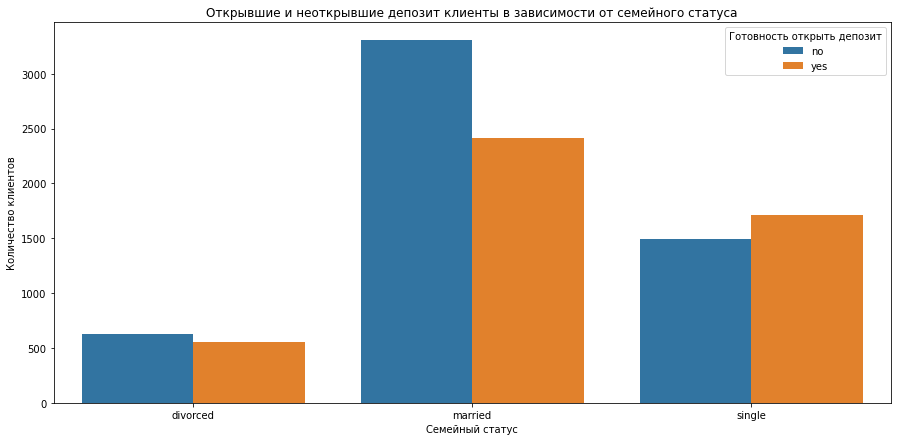

In [359]:
marital_deposit = df.groupby("marital", as_index=False)["deposit"].value_counts()

fig, ax = plt.subplots(figsize=(15, 7))
sns.barplot(
    data=marital_deposit,
    x="marital",
    y='count',
    hue='deposit',
    ax=ax
)
ax.set_title("Открывшие и неоткрывшие депозит клиенты в зависимости от семейного статуса")
ax.set_xlabel("Семейный статус")
ax.set_ylabel("Количество клиентов")
plt.legend(title="Готовность открыть депозит", loc='upper right');

Большего всего неготовых открыть депозит - люди в браке. Возможно, стоит создать выгодные предложения для семейных людей, тем более, что много клиентов не брали ипотеку и являются добропорядочными плательщиками по кредиту. Ипотека и ипотечные условия, а также выгодные условия для предпринимателей могут привлечь эту категорию клиентов.

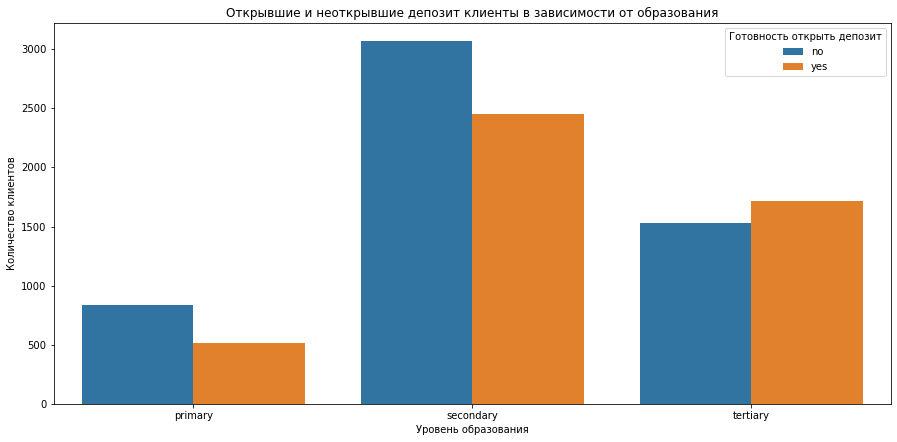

In [360]:
education_deposit = df.groupby("education", as_index=False)["deposit"].value_counts()

fig, ax = plt.subplots(figsize=(15, 7))
sns.barplot(
    data=education_deposit,
    x="education",
    y='count',
    hue='deposit',
    ax=ax
)
ax.set_title("Открывшие и неоткрывшие депозит клиенты в зависимости от образования")
ax.set_xlabel("Уровень образования")
ax.set_ylabel("Количество клиентов")
plt.legend(title="Готовность открыть депозит", loc='upper right');

Из всех групп клиентов по образованию больше готовых открыть депозит клиенты с высшим образованием.

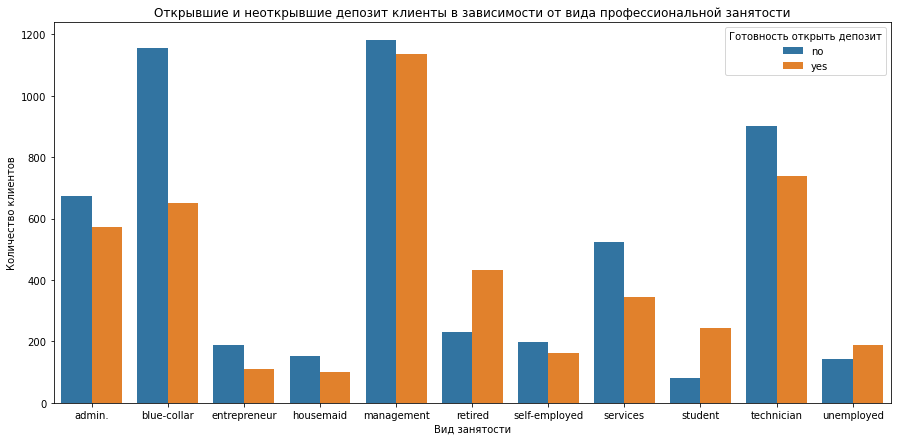

In [361]:
job_deposit = df.groupby("job", as_index=False)["deposit"].value_counts()

fig, ax = plt.subplots(figsize=(15, 7))
sns.barplot(
    data=job_deposit,
    x="job",
    y='count',
    hue='deposit',
    ax=ax
)
ax.set_title("Открывшие и неоткрывшие депозит клиенты в зависимости от вида профессиональной занятости")
ax.set_xlabel("Вид занятости")
ax.set_ylabel("Количество клиентов")
plt.legend(title="Готовность открыть депозит", loc='upper right');

In [362]:
# В какой сфере занято наибольшее число клиентов банка?
np.round(df["job"].value_counts(normalize=True)*100, 2)

management       22.91
blue-collar      17.88
technician       16.21
admin.           12.33
services          8.59
retired           6.56
self-employed     3.54
unemployed        3.29
student           3.23
entrepreneur      2.97
housemaid         2.49
Name: job, dtype: float64

Большинство клиентов работают в сфере менеджмента.

Посмотрим на пересечение категорий:

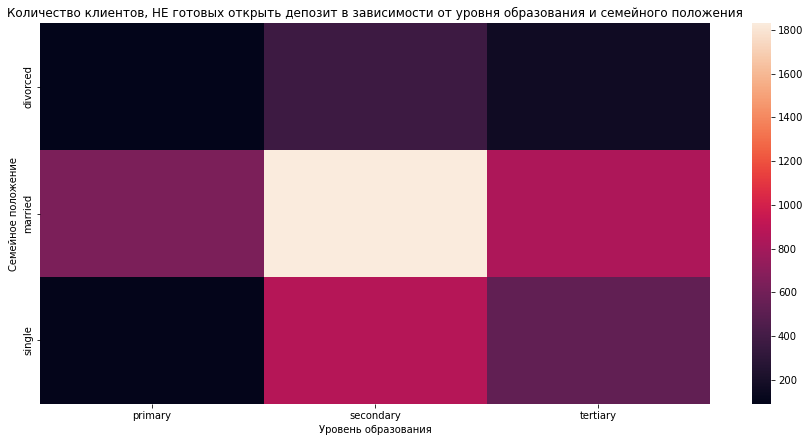

In [363]:
df1 = df[df["deposit"] == "no"].pivot_table(
    values="deposit",
    index="marital",
    columns="education",
    aggfunc="count"
)
df1

fig, ax = plt.subplots(figsize=(15, 7))
sns.heatmap(df1, ax=ax)
ax.set_title("Количество клиентов, НЕ готовых открыть депозит в зависимости от уровня образования и семейного положения")
ax.set_xlabel("Уровень образования")
ax.set_ylabel("Семейное положение");

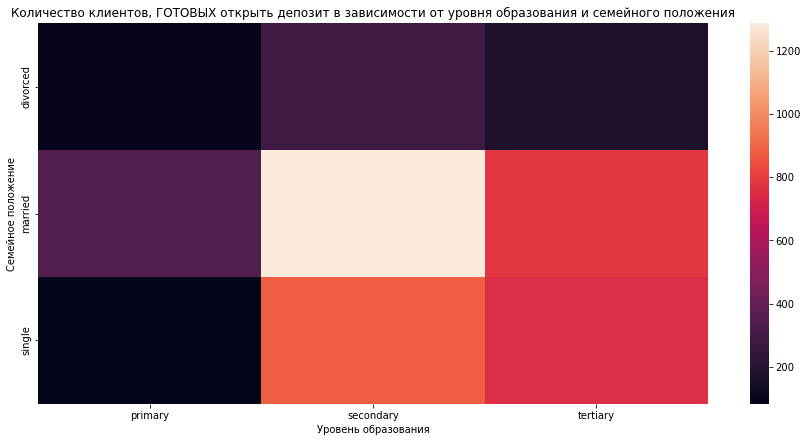

In [364]:
df2 = df[df["deposit"] == "yes"].pivot_table(
    values="deposit",
    index="marital",
    columns="education",
    aggfunc="count"
)
df2

fig, ax = plt.subplots(figsize=(15, 7))
sns.heatmap(df2, ax=ax)
ax.set_title("Количество клиентов, ГОТОВЫХ открыть депозит в зависимости от уровня образования и семейного положения")
ax.set_xlabel("Уровень образования")
ax.set_ylabel("Семейное положение");

Из двух тепловых карт видно, что упор в привлечении надо делать на клиентов со средним образованием и состоящих в браке.

## Преобразование данных

Начнём с обработки категориального порядкового признака, который отвечает за уровень образования: education.

Обработаем его с помощью метода LabelEncoder, используя метод без дополнительных настроек. 

In [365]:
l_encoder = LabelEncoder()
df["education"] = l_encoder.fit_transform(df["education"])

In [366]:
df["age_group"] = l_encoder.fit_transform(df["age_group"])

Обычно в задачах бинарной классификации целевую переменную кодируют как бинарный признак, который принимает значения 1 или 0. Перекодируем переменную deposit таким образом, чтобы вместо yes она принимала значение 1, а вместо no — 0.

In [367]:
df["deposit"] = df["deposit"].apply(lambda x: 1 if x == "yes" else 0)

# сделаем то же самое для других бинарных переменных:
df["housing"] = df["housing"].apply(lambda x: 1 if x == "yes" else 0)
df["loan"] = df["loan"].apply(lambda x: 1 if x == "yes" else 0)
df["default"] = df["default"].apply(lambda x: 1 if x == "yes" else 0)

Теперь нам необходимо преобразовать номинальные переменные, которые могут принимать несколько различных значений. Это следующие переменные:

* 'job';
* 'marital';
* 'contact';
* 'month';
* 'poutcome'.

In [368]:
# создадим дамми-переменные
df_dummies = pd.get_dummies(df[['job', 'marital', 'contact', 'month', 'poutcome']])
df = pd.concat([df, df_dummies], axis=1)

In [369]:
df.shape

(10105, 51)

Оценим мультиколлинеарность и взаимосвязь признаков с целевой переменной.

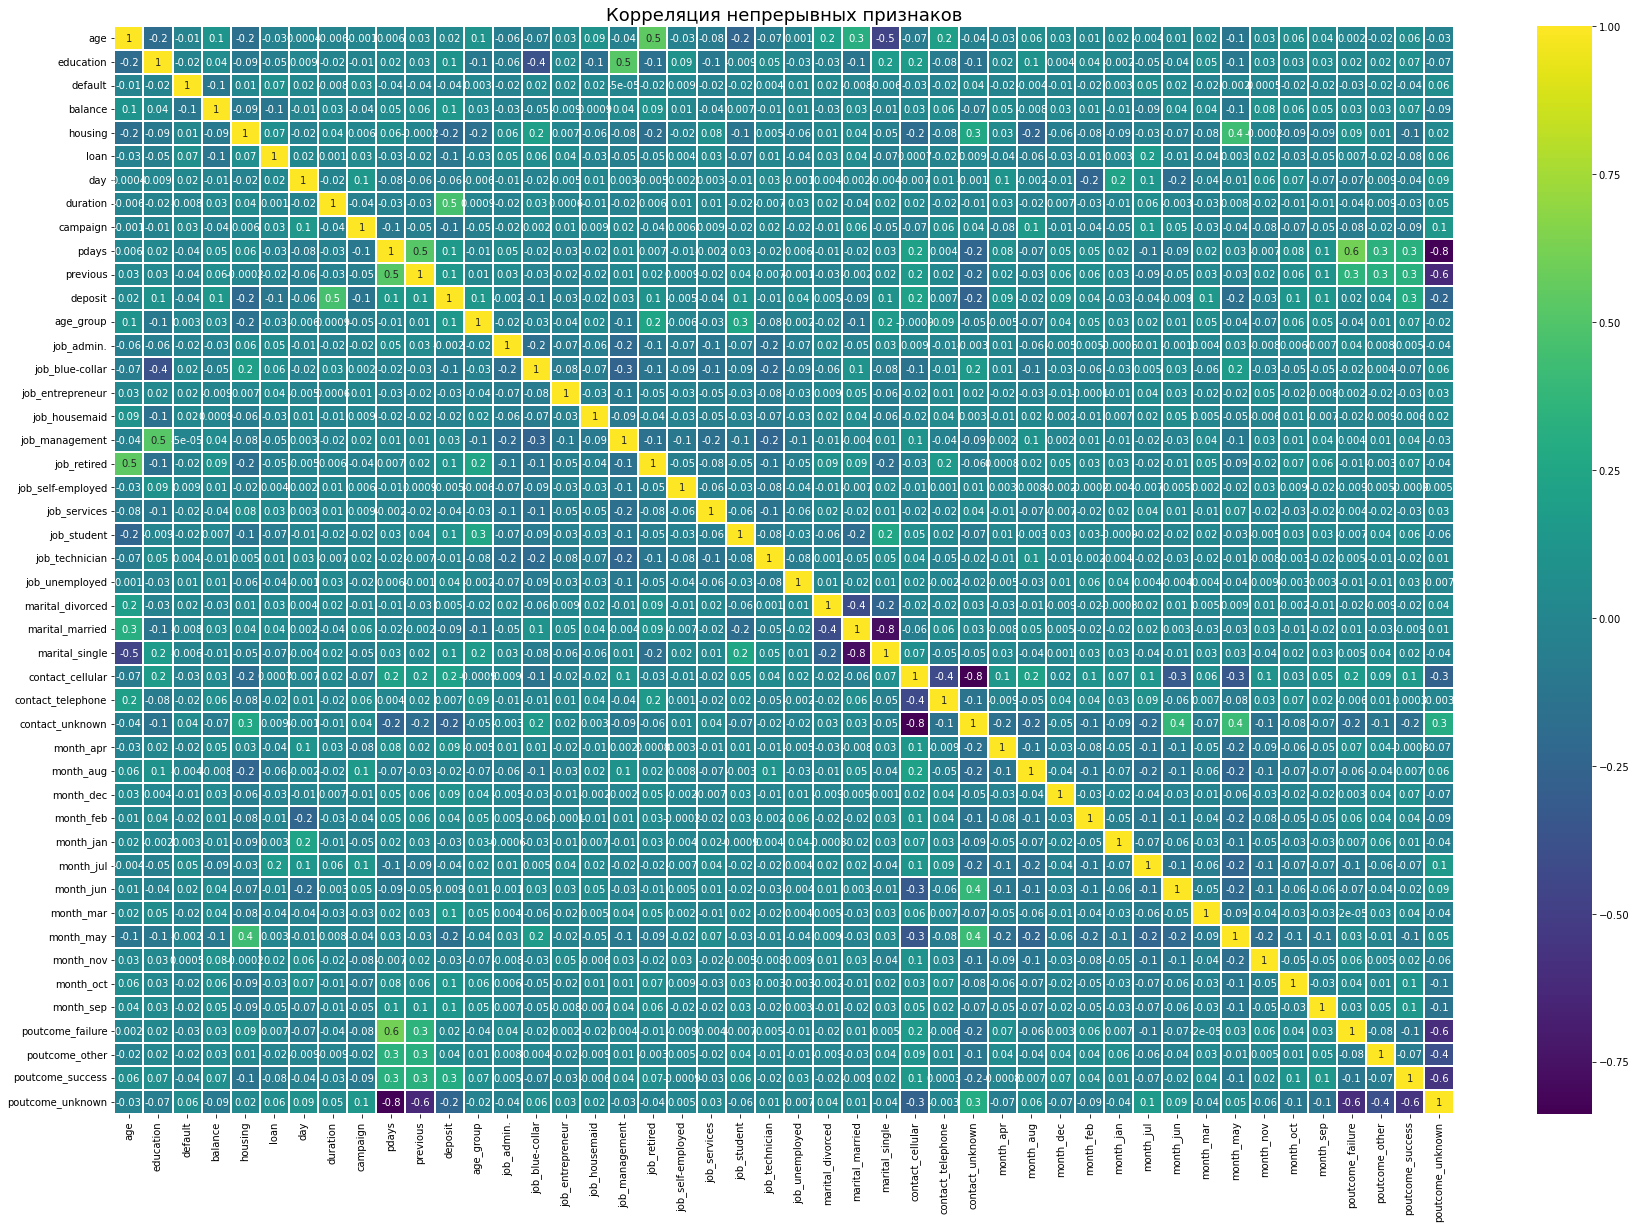

In [370]:
fig, ax = plt.subplots(figsize=(30, 20))
corr = df.corr(method='pearson')
sns.heatmap(corr, 
            annot=True, 
            linewidths=0.1, 
            ax=ax, 
            cmap='viridis',
            fmt='.1g')
ax.set_title('Корреляция непрерывных признаков', fontsize=18)
plt.show()

Будем считать достаточно сильной корреляцию не менее 0.9. Удаляем сильно коррелирующие признаки.

In [371]:
df = df.drop(["job", "marital", "contact", "month", "poutcome"], axis=1)

Теперь необходимо определить целевую переменную и предикторы, а также разделить выборку на обучающую и тестовую.

In [372]:
X = df.drop(['deposit'], axis=1)
y = df['deposit']
 
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state = 42, test_size = 0.33)

In [373]:
X_test.shape[0]

3335

In [374]:
round(y_test.mean(), 2)

0.46

На данный момент у нас достаточно много признаков: скорее всего, не все из них будут важны. Оставим лишь те, которые сильнее всего связаны с целевой переменной и точно будут вносить вклад в повышение качества модели.

С помощью SelectKBest отберём 15 признаков, наилучшим образом подходящих для использования в задаче.

In [375]:
selector = SelectKBest(f_classif, k=15)
selector.fit(X_train, y_train)
 
selector.get_feature_names_out()

array(['balance', 'housing', 'duration', 'campaign', 'pdays', 'previous',
       'age_group', 'contact_cellular', 'contact_unknown', 'month_mar',
       'month_may', 'month_oct', 'month_sep', 'poutcome_success',
       'poutcome_unknown'], dtype=object)

In [376]:
X_train_best = X_train[selector.get_feature_names_out()]
X_test_best = X_test[selector.get_feature_names_out()]

Нормализуем данные.

In [377]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
scaler.fit(X_train_best)
scaler.get_feature_names_out()

array(['balance', 'housing', 'duration', 'campaign', 'pdays', 'previous',
       'age_group', 'contact_cellular', 'contact_unknown', 'month_mar',
       'month_may', 'month_oct', 'month_sep', 'poutcome_success',
       'poutcome_unknown'], dtype=object)

In [378]:
X_train_best_scaled = pd.DataFrame(scaler.transform(X_train_best), columns=scaler.get_feature_names_out())
X_test_best_scaled = pd.DataFrame(scaler.transform(X_test_best), columns=scaler.get_feature_names_out())

In [379]:
round(X_test_best_scaled.iloc[:,0].mean(), 2)

0.47

# Решение задачи классификации: логистическая регрессия и решающие деревья

Реализуем самый простой алгоритм — логистическую регрессию. В качестве алгоритма оптимизации будем использовать 'sag'.

Оценим качество модели на тестовой выборке.

In [380]:
log_reg = linear_model.LogisticRegression(solver="sag", max_iter=1000, random_state=42)

log_reg.fit(X_train_best_scaled, y_train)

LogisticRegression(max_iter=1000, random_state=42, solver='sag')

In [381]:
print(f"Значение метрики accuracy на тестовой выборке: {np.round(metrics.accuracy_score(y_test, log_reg.predict(X_test_best_scaled)), 2)}")

Значение метрики accuracy на тестовой выборке: 0.81


Обучим ещё один алгоритм — решающие деревья. 

In [382]:
from sklearn.tree import DecisionTreeClassifier

dt = DecisionTreeClassifier(criterion="entropy", random_state=42)
dt.fit(X_train_best_scaled, y_train)

DecisionTreeClassifier(criterion='entropy', random_state=42)

In [383]:
print(metrics.classification_report(y_train, dt.predict(X_train_best_scaled)))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3634
           1       1.00      1.00      1.00      3136

    accuracy                           1.00      6770
   macro avg       1.00      1.00      1.00      6770
weighted avg       1.00      1.00      1.00      6770



In [384]:
print(metrics.classification_report(y_test, dt.predict(X_test_best_scaled)))

              precision    recall  f1-score   support

           0       0.77      0.77      0.77      1790
           1       0.74      0.73      0.73      1545

    accuracy                           0.75      3335
   macro avg       0.75      0.75      0.75      3335
weighted avg       0.75      0.75      0.75      3335



На лицо переобучение.

In [385]:
dt.get_depth()

36

Уменьшим глубину дерева для борьбы с переобучением до 6.

In [386]:
dt1 = DecisionTreeClassifier(criterion="entropy", random_state=42, max_depth=6)
dt1.fit(X_train_best_scaled, y_train)

print(f"Значения метрик на обучающем наборе:\n{metrics.classification_report(y_train, dt1.predict(X_train_best_scaled))}")
print(f"Значения метрик на тестовом наборе:\n{metrics.classification_report(y_test, dt1.predict(X_test_best_scaled))}")

Значения метрик на обучающем наборе:
              precision    recall  f1-score   support

           0       0.86      0.79      0.82      3634
           1       0.78      0.85      0.81      3136

    accuracy                           0.82      6770
   macro avg       0.82      0.82      0.82      6770
weighted avg       0.82      0.82      0.82      6770

Значения метрик на тестовом наборе:
              precision    recall  f1-score   support

           0       0.85      0.78      0.82      1790
           1       0.77      0.84      0.80      1545

    accuracy                           0.81      3335
   macro avg       0.81      0.81      0.81      3335
weighted avg       0.81      0.81      0.81      3335



Значения метрик на обоих наборах, после уменьшения глубины решающего дерева, практически равны.

У каждой модели может быть множество параметров. Перебирать их вручную, чтобы получить наилучшее качество, долго и трудозатратно. Поэтому можем использовать оптимизацию.

In [387]:
# подбираем оптимальные параметры с помощью gridsearch
from sklearn.model_selection import GridSearchCV

param_grid = {
    'min_samples_split': [2, 5, 7, 10],
    'max_depth': [3,5,7]
}

grid_search = GridSearchCV(
    estimator=tree.DecisionTreeClassifier(random_state=42, criterion="entropy"),
    param_grid=param_grid,
    cv=5,
    n_jobs=-1
)

grid_search.fit(X_train_best_scaled, y_train)

GridSearchCV(cv=5,
             estimator=DecisionTreeClassifier(criterion='entropy',
                                              random_state=42),
             n_jobs=-1,
             param_grid={'max_depth': [3, 5, 7],
                         'min_samples_split': [2, 5, 7, 10]})

In [388]:
print(f"Наилучшие значения параметров: {grid_search.best_params_}")

Наилучшие значения параметров: {'max_depth': 7, 'min_samples_split': 10}


In [389]:
print("F1-score на тестовой выборке с подобранными по сетке гиперпараметрами: {:.2f}".format(metrics.f1_score(y_test, grid_search.predict(X_test_best_scaled))))

F1-score на тестовой выборке с подобранными по сетке гиперпараметрами: 0.80


# Решение задачи классификации: ансамбли моделей и построение прогноза

Обучим случайный лес.

In [390]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(
    n_estimators = 100,
    criterion = 'gini',
    min_samples_leaf = 5,
    max_depth = 10,
    random_state = 42
)

rf.fit(X_train_best_scaled, y_train)

RandomForestClassifier(max_depth=10, min_samples_leaf=5, random_state=42)

In [391]:
print(f"Значения метрик на тестовом наборе:\n{metrics.classification_report(y_test, rf.predict(X_test_best_scaled))}")

Значения метрик на тестовом наборе:
              precision    recall  f1-score   support

           0       0.85      0.82      0.84      1790
           1       0.80      0.83      0.82      1545

    accuracy                           0.83      3335
   macro avg       0.83      0.83      0.83      3335
weighted avg       0.83      0.83      0.83      3335



Сравним полученные результаты с моделью градиентного бустинга.

In [392]:
from sklearn.ensemble import GradientBoostingClassifier

gbc = GradientBoostingClassifier(
    learning_rate = 0.05,
    n_estimators = 300,
    min_samples_leaf = 5,
    max_depth = 5,
    random_state = 42
)

gbc.fit(X_train_best_scaled, y_train)

GradientBoostingClassifier(learning_rate=0.05, max_depth=5, min_samples_leaf=5,
                           n_estimators=300, random_state=42)

In [393]:
print(f"Значения метрик на тестовом наборе:\n{metrics.classification_report(y_test, gbc.predict(X_test_best_scaled))}")

Значения метрик на тестовом наборе:
              precision    recall  f1-score   support

           0       0.85      0.82      0.84      1790
           1       0.80      0.83      0.82      1545

    accuracy                           0.83      3335
   macro avg       0.83      0.83      0.83      3335
weighted avg       0.83      0.83      0.83      3335



Сравнивая метрики по обеим моделям, можно сделать вывод, что обе неплохо справляются, но на градиентный бустинг уходит больше времени.

Ранее построили разные модели, и теперь можно построить ансамбль из моделей разного типа.

Будем использовать стекинг, объединив те алгоритмы, которые уже использовали ранее: решающие деревья, логистическую регрессию и градиентный бустинг. В качестве метамодели используем самую простую - модель логистической регрессии.



In [394]:
from sklearn.ensemble import StackingClassifier

estimators = [("log_reg", linear_model.LogisticRegression(solver="sag", max_iter=1000, random_state=42)),
              ("dt", DecisionTreeClassifier(criterion="entropy", random_state=42)),
              ("grid_search", GridSearchCV(estimator=tree.DecisionTreeClassifier(random_state=42, criterion="entropy"),
                        param_grid=param_grid,
                        cv=5,
                        n_jobs=-1)),
              ("rf", RandomForestClassifier(n_estimators = 100,
                        criterion = 'gini',
                        min_samples_leaf = 5,
                        max_depth = 10,
                        random_state = 42)),
              ("gbc", GradientBoostingClassifier(
                        learning_rate = 0.05,
                        n_estimators = 300,
                        min_samples_leaf = 5,
                        max_depth = 5,
                        random_state = 42
))
              ]

reg = StackingClassifier(estimators=estimators, final_estimator=linear_model.LogisticRegression(max_iter=1000, random_state=42))

In [395]:
reg.fit(X_train_best_scaled, y_train)
y_pred_stack = reg.predict(X_test_best_scaled)

In [396]:
print("Точность модели на тестовом наборе (precision): {:.2f}".format(metrics.precision_score(y_test, y_pred_stack)))

Точность модели на тестовом наборе (precision): 0.81


Не все признаки одинаково хорошо предсказывают результат маркетинговой кампании. Для того чтобы отобрать наиболее значимые для нас аспекты, на которые надо будет обратить внимание при реализации следующей акции, давайте выберем три признака, дающих наибольший вклад.

In [397]:
selector = SelectKBest(f_classif, k=3)
selector.fit(X_train_best_scaled, y_train)
 
selector.get_feature_names_out()

array(['duration', 'contact_unknown', 'poutcome_success'], dtype=object)

In [398]:
from sklearn.feature_selection import RFE

estimator = GradientBoostingClassifier()
selector = RFE(estimator, n_features_to_select=3, step=1)
selector.fit(X_train_best_scaled, y_train)
selector.get_feature_names_out()

array(['duration', 'contact_unknown', 'poutcome_success'], dtype=object)

Была рассмотрена оптимизация гиперпараметров при помощи GridSearch. Однако это не единственный способ. Один из более продвинутых вариантов оптимизации гиперпараметров — фреймворк Optuna. Применим его для оптимизации гиперпараметров. Для перебора возьмём случайный лес.

In [399]:
def optuna_rf(trial, cv=5, X=X_train_best_scaled, y=y_train, random_state=42):
    
    n_estimators = trial.suggest_int('n_estimators', 100, 200, 1)
    max_depth = trial.suggest_int('max_depth', 10, 30, 1)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 2, 10, 1)

    model = ensemble.RandomForestClassifier(n_estimators=n_estimators,
                                          max_depth=max_depth,
                                          min_samples_leaf=min_samples_leaf,
                                          random_state=random_state)
  
    model.fit(X, y)
    score = cross_val_score(model, X, y, cv=cv, scoring="f1", n_jobs=-1).mean()


    return score

In [400]:
import optuna
from sklearn.model_selection import cross_val_score

study = optuna.create_study(study_name="RandomForestClassifier", direction="maximize")
study.optimize(optuna_rf, n_trials=50)

[I 2022-11-20 18:21:53,418] A new study created in memory with name: RandomForestClassifier
[I 2022-11-20 18:21:55,861] Trial 0 finished with value: 0.8249779902231278 and parameters: {'n_estimators': 194, 'max_depth': 20, 'min_samples_leaf': 7}. Best is trial 0 with value: 0.8249779902231278.
[I 2022-11-20 18:21:57,213] Trial 1 finished with value: 0.8270802371611164 and parameters: {'n_estimators': 108, 'max_depth': 18, 'min_samples_leaf': 3}. Best is trial 1 with value: 0.8270802371611164.
[I 2022-11-20 18:21:58,396] Trial 2 finished with value: 0.8210403696571822 and parameters: {'n_estimators': 115, 'max_depth': 27, 'min_samples_leaf': 10}. Best is trial 1 with value: 0.8270802371611164.
[I 2022-11-20 18:21:59,484] Trial 3 finished with value: 0.8202666900386457 and parameters: {'n_estimators': 106, 'max_depth': 16, 'min_samples_leaf': 10}. Best is trial 1 with value: 0.8270802371611164.
[I 2022-11-20 18:22:01,717] Trial 4 finished with value: 0.8253743530460751 and parameters: {'

In [401]:
print("Наилучшие значения гиперпараметров {}".format(study.best_params))
print("f1_score на обучающем наборе: {:.3f}".format(study.best_value))

Наилучшие значения гиперпараметров {'n_estimators': 148, 'max_depth': 22, 'min_samples_leaf': 2}
f1_score на обучающем наборе: 0.830


In [402]:
rf_opt = RandomForestClassifier(n_estimators = 183, max_depth = 21, min_samples_leaf = 3, random_state=42)
rf_opt.fit(X_train_best_scaled, y_train)
rf_opt.predict(X_test_best_scaled)

array([1, 0, 0, ..., 0, 1, 1])

In [403]:
print('f1_score на тестовом наборе: {:.2f}'.format(metrics.f1_score(y_test, rf_opt.predict(X_test_best_scaled))))

f1_score на тестовом наборе: 0.82


In [404]:
print('accuracy на тестовом наборе: {:.2f}'.format(metrics.accuracy_score(y_test, rf_opt.predict(X_test_best_scaled))))

accuracy на тестовом наборе: 0.83


In [405]:
y_true = [1.23, 2.35, 2.75]
y_pred = [1.01, 12.3, 2.74]
mse = metrics.mean_squared_error(y_true, y_pred)
rmse = mse**0.5
print(round(rmse, 2))

5.75


Как видим, качество модели случайного леса улучшилась.